In [59]:
import cv2
import os
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

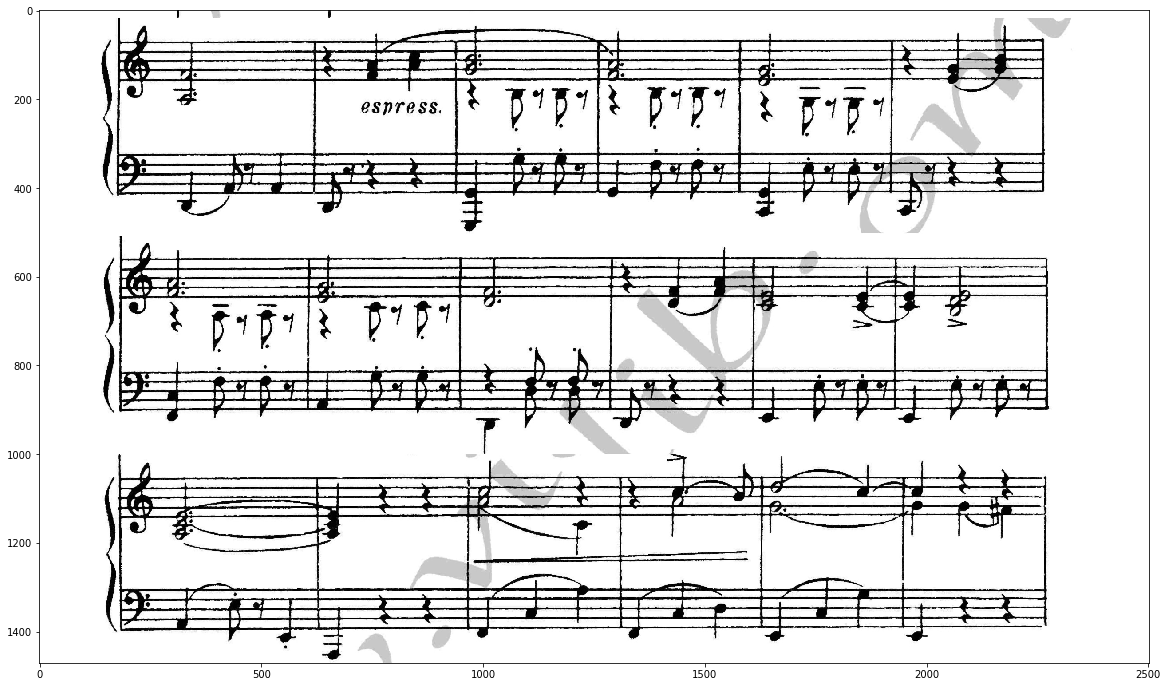

In [121]:
# Reading the file
note_path = 'note.jpg'
note = cv2.imread(note_path)
note = cv2.cvtColor(note, cv2.COLOR_BGR2GRAY)
note = cv2.medianBlur(note, 3)

# Let's just work with the bottom half first
note = note[note.shape[0] // 2 + 200:, :]

# Let's see what we have now, visualization is very important
plt.figure(figsize=(20, 12))
plt.imshow(note, 'gray')

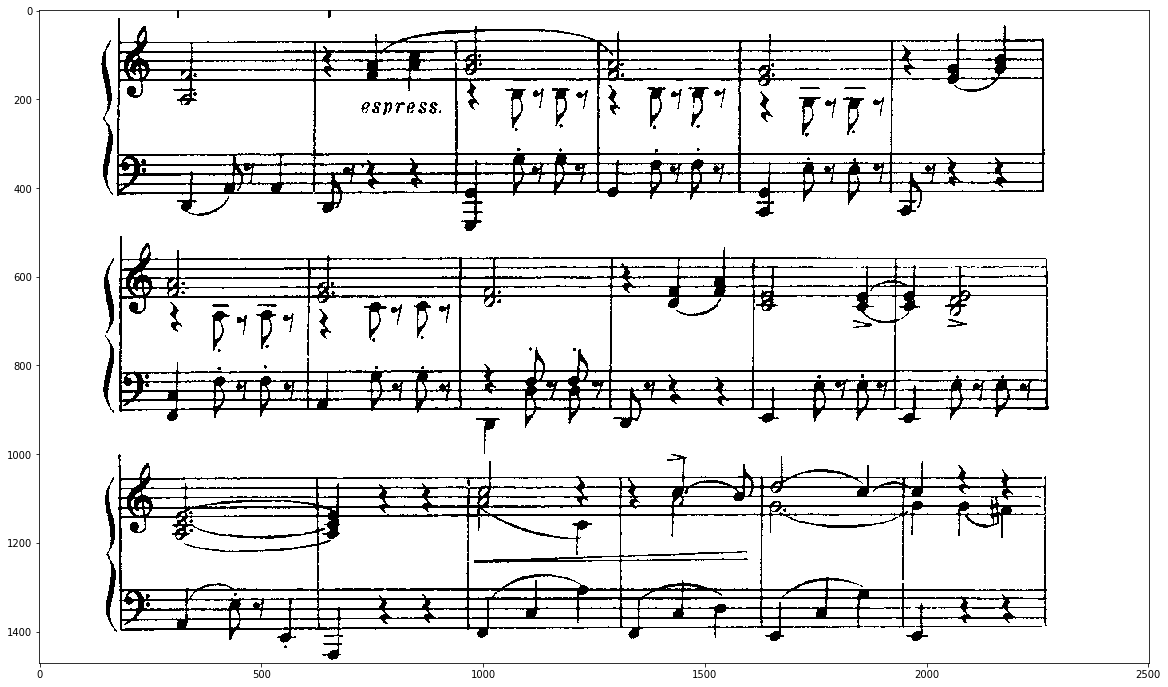

In [122]:
# Filter out the gray stuff, custom step
ret, thresh = cv2.threshold(note, 127, 255, cv2.THRESH_BINARY)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(thresh, 'gray')

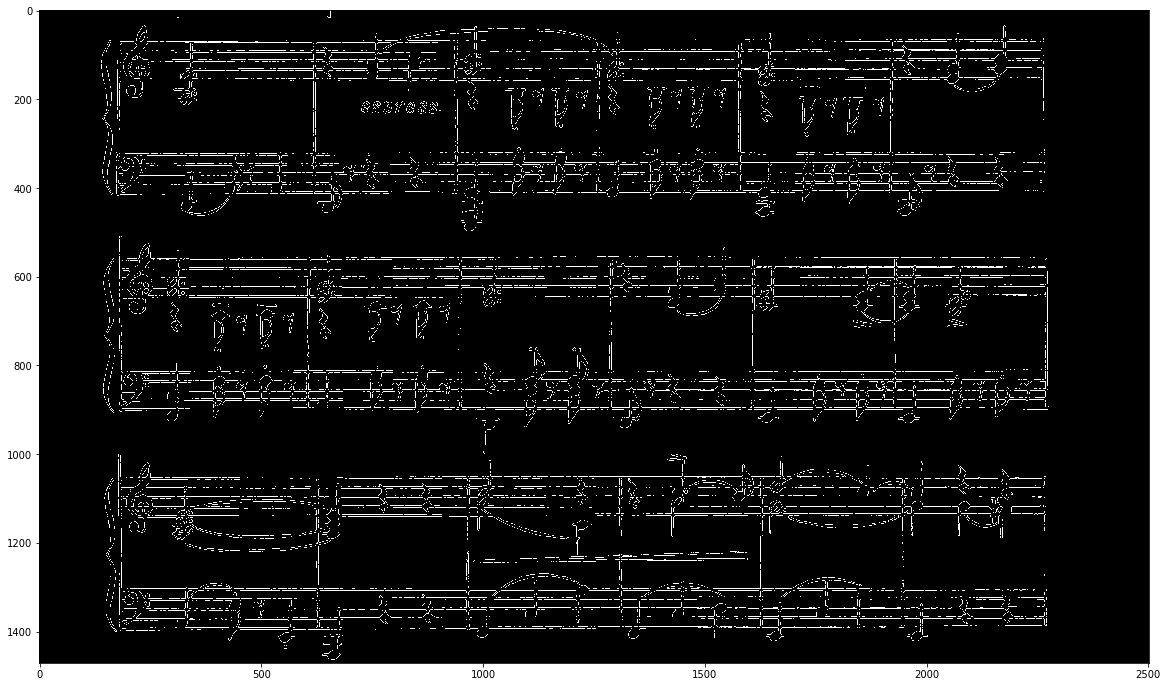

In [129]:
# Detect horizontal edges
edges = cv2.Canny(thresh, 100, 200, None, 3)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(edges,cmap = 'gray')

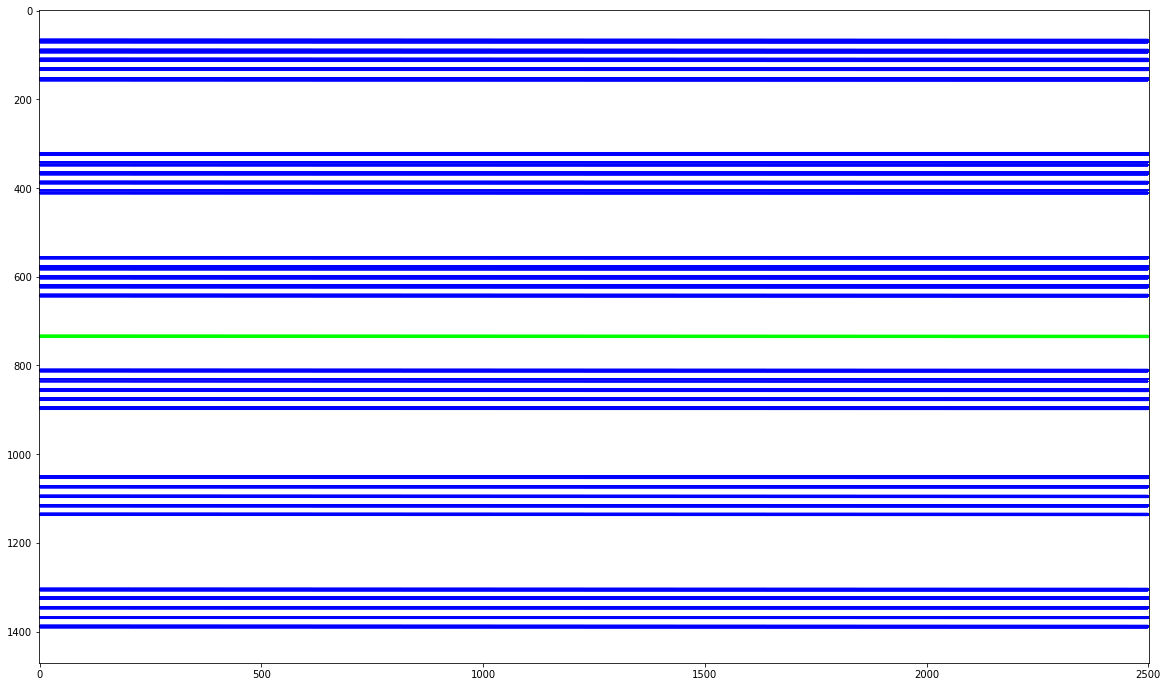

In [204]:
def display_line(img, rho, theta, thicc=3, color=(0, 0, 0)):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 3000*(-b)), int(y0 + 3000*(a)))
    pt2 = (int(x0 - 3000*(-b)), int(y0 - 3000*(a)))
    cv2.line(img, pt1, pt2, color, thicc, cv2.LINE_AA)

# Copy of image
#bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
bgr_thresh = np.ones(bgr_thresh.shape, dtype=np.uint8) * 255

# Find lines from edges
lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)
assert lines is not None

# Predominant angle
thetas = lines[:, 0, 1]
thetas_std = np.std(thetas)
thetas_mean = np.mean(thetas)
thetas = thetas[(thetas_mean - thetas_std - 1e-4 < thetas) &
                (thetas < thetas_mean + thetas_std + 1e-4)]
predominant_angle = np.median(thetas)

# Filter out lines that does not match the dominant direction
thetas = lines[:, 0, 1]
lines = lines[(predominant_angle - 1e-2 < thetas) &
              (thetas < predominant_angle + 1e-2)]

# Sort the lines by rho value
rhos = lines[:, 0, 0]
args = np.argsort(rhos)
lines = lines[args, :, :]

# Visualize lines and the dominant direction
rho = bgr_thresh.shape[0] // 2
theta = predominant_angle
display_line(bgr_thresh, rho, theta, 7, (0, 255, 0))
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    display_line(bgr_thresh, rho, theta, 3, (0, 0, 255))
plt.figure(figsize=(20, 12))
plt.imshow(bgr_thresh, 'gray')

In [205]:
# TODO: Rotate the image in such a way, so that the predominant angle
# become horizontal
predominant_angle = predominant_angle

in-band range: 19.0 ... 23.0
ex-band range: 148.0 ... 169.0
number of bands: 6
before filtering lines: 72  lines
after filtering proper lines: 30  lines


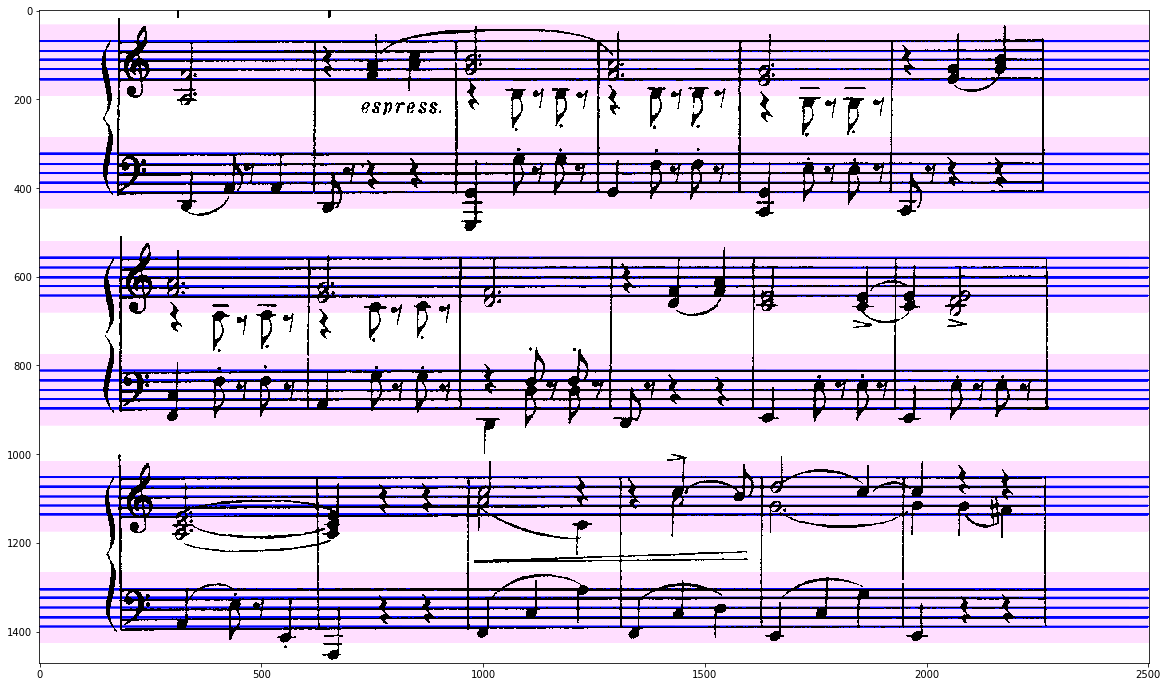

In [207]:
# Filter out the lines that are too close to each other
linewidth_threshold = 7
proper_lines = []
lines_pool = []
prev_rho = None
for i in range(len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    if prev_rho is None:
        prev_dst = 1000000
    else:
        prev_dst = abs(rho - prev_rho)
    if len(lines_pool) != 0:
        if prev_dst > linewidth_threshold:
            avg_rho = np.round(np.mean(np.array(lines_pool)[:, 0]))
            avg_theta = np.mean(np.array(lines_pool)[:, 1])
            proper_lines.append([avg_rho, avg_theta])
            lines_pool = []
    prev_rho = rho
    lines_pool.append([rho, theta])

avg_rho = np.mean(np.array(lines_pool)[:, 0])
avg_theta = np.mean(np.array(lines_pool)[:, 1])
proper_lines.append([avg_rho, avg_theta])
proper_lines = np.array(proper_lines)[:, np.newaxis, :]

# Find the bands
rho_cp = proper_lines[:, 0, 0].copy()
rho_le = np.concatenate((np.zeros((1)), rho_cp))
rho_ri = np.concatenate((rho_cp, np.zeros((1))))
rho_dt = rho_le - rho_ri
rho_dt = np.abs(rho_dt[1:-1])
rho_inband_min = np.min(rho_dt)
rho_exband_max = np.max(rho_dt)
rho_inband_max = rho_inband_min
rho_exband_min = rho_exband_max
for rho in rho_dt:
    if abs(rho - rho_inband_min) < abs(rho - rho_exband_max):
        rho_inband_max = max(rho, rho_inband_max)
    else:
        rho_exband_min = min(rho, rho_exband_min)
print('in-band range:', rho_inband_min, '...', rho_inband_max)
print('ex-band range:', rho_exband_min, '...', rho_exband_max)
band_list = []
band_pool = []
prev_rho = None
for i in range(len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    if prev_rho is not None:
        if abs(rho - prev_rho) <= rho_inband_max:
            None
        if abs(rho - prev_rho) >= rho_exband_min:
            band_pool = np.array(band_pool)
            band_list.append([
                np.round(np.mean(band_pool[:, 0])),
                np.mean(band_pool[:, 1]),
                abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
            band_pool = []
    band_pool.append([rho, theta])
    prev_rho = rho
band_pool = np.array(band_pool)
band_list.append([
    np.round(np.mean(band_pool[:, 0])),
    np.mean(band_pool[:, 1]),
    abs(np.max(band_pool[:, 0]) - np.min(band_pool[:, 0]))])
band_list = np.array(band_list)[:, np.newaxis, :]
print('number of bands:', band_list.shape[0])

# Visualize the proper lines
print('before filtering lines:', lines.shape[0], ' lines')
print('after filtering proper lines:', proper_lines.shape[0], ' lines')
white = np.ones(bgr_thresh.shape, dtype=np.uint8) * 255
bgr_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for i in range(0, len(band_list)):
    rho = band_list[i][0][0]
    theta = band_list[i][0][1]
    thicc = band_list[i][0][2]
    display_line(white, rho, theta, int(thicc + rho_exband_min // 2), (255, 222, 255))
for i in range(0, len(proper_lines)):
    rho = proper_lines[i][0][0]
    theta = proper_lines[i][0][1]
    display_line(white, rho, theta, 3, (0, 0, 255))
bgr_thresh = np.minimum(bgr_thresh, white)
plt.figure(figsize=(20, 12))
plt.imshow(bgr_thresh, 'gray')

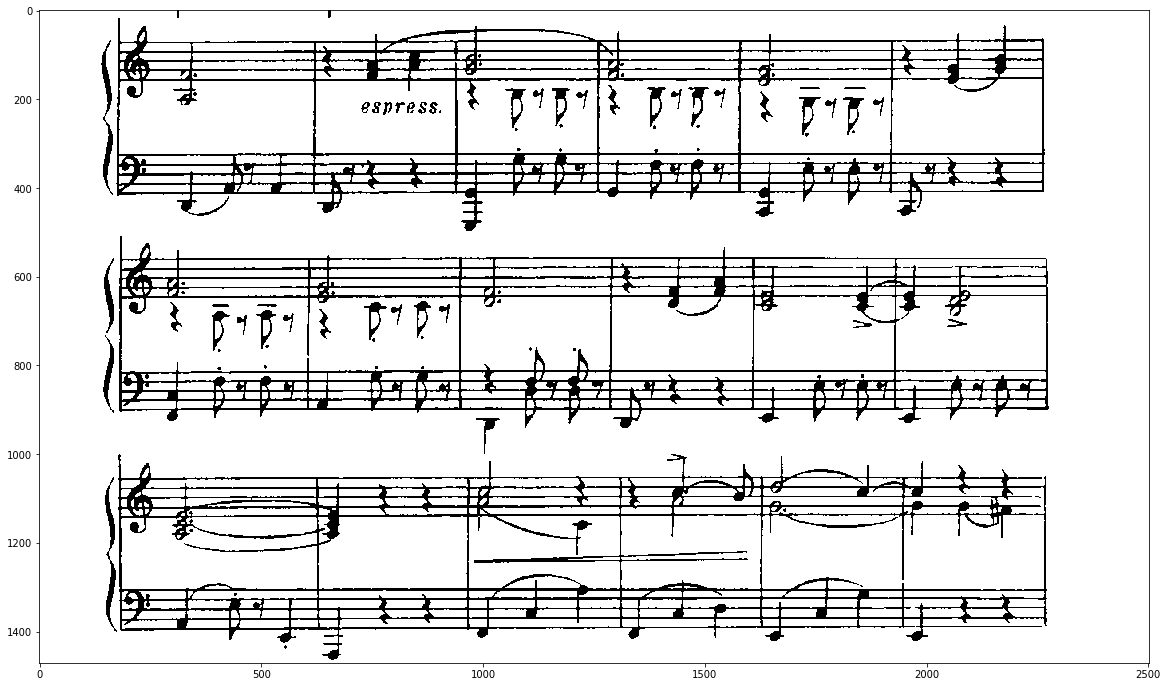

In [229]:
# Let's try to recognize the dots
morphed = thresh.copy()
kernel3 = np.ones((3, 3), np.uint8)
kernel5 = np.ones((5, 5), np.uint8)
erosion = cv2.erode(thresh, kernel3, iterations=1)
dilation = cv2.dilate(erosion, kernel3, iterations=1)

# Visualization
plt.figure(figsize=(20, 12))
plt.imshow(dilation, 'gray')

In [228]:
def fit(img, templates, start_percent, stop_percent, threshold):
    img_width, img_height = img.shape[::-1]
    best_location_count = -1
    best_locations = []
    best_scale = 1

    plt.axis([0, 2, 0, 1])
    plt.show(block=False)

    x = []
    y = []
    for scale in [i/100.0 for i in range(start_percent, stop_percent + 1, 3)]:
        locations = []
        location_count = 0
        for template in templates:
            template = cv2.resize(template, None,
                fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
            result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            result = np.where(result >= threshold)
            location_count += len(result[0])
            locations += [result]
        print("scale: {0}, hits: {1}".format(scale, location_count))
        x.append(location_count)
        y.append(scale)
        plt.plot(y, x)
        plt.pause(0.00001)
        if (location_count > best_location_count):
            best_location_count = location_count
            best_locations = locations
            best_scale = scale
            plt.axis([0, 2, 0, best_location_count])
        elif (location_count < best_location_count):
            pass
    plt.close()
    return best_locations, best_scale

def locate_images(img, templates, start, stop, threshold):
    locations, scale = fit(img, templates, start, stop, threshold)
    img_locations = []
    for i in range(len(templates)):
        w, h = templates[i].shape[::-1]
        w *= scale
        h *= scale
        img_locations.append([Rectangle(pt[0], pt[1], w, h) for pt in zip(*locations[i][::-1])])
    return img_locations

def merge_recs(recs, threshold):
    filtered_recs = []
    while len(recs) > 0:
        r = recs.pop(0)
        recs.sort(key=lambda rec: rec.distance(r))
        merged = True
        while(merged):
            merged = False
            i = 0
            for _ in range(len(recs)):
                if r.overlap(recs[i]) > threshold or recs[i].overlap(r) > threshold:
                    r = r.merge(recs.pop(i))
                    merged = True
                elif recs[i].distance(r) > r.w/2 + recs[i].w/2:
                    break
                else:
                    i += 1
        filtered_recs.append(r)
    return filtered_recs


staff_files = [
    "resources/template/staff2.png", 
    "resources/template/staff.png"]
quarter_files = [
    "resources/template/quarter.png", 
    "resources/template/solid-note.png"]
sharp_files = [
    "resources/template/sharp.png"]
flat_files = [
    "resources/template/flat-line.png", 
    "resources/template/flat-space.png" ]
half_files = [
    "resources/template/half-space.png", 
    "resources/template/half-note-line.png",
    "resources/template/half-line.png", 
    "resources/template/half-note-space.png"]
whole_files = [
    "resources/template/whole-space.png", 
    "resources/template/whole-note-line.png",
    "resources/template/whole-line.png", 
    "resources/template/whole-note-space.png"]

staff_imgs = [cv2.imread(staff_file, 0) for staff_file in staff_files]
quarter_imgs = [cv2.imread(quarter_file, 0) for quarter_file in quarter_files]
sharp_imgs = [cv2.imread(sharp_files, 0) for sharp_files in sharp_files]
flat_imgs = [cv2.imread(flat_file, 0) for flat_file in flat_files]
half_imgs = [cv2.imread(half_file, 0) for half_file in half_files]
whole_imgs = [cv2.imread(whole_file, 0) for whole_file in whole_files]

staff_lower, staff_upper, staff_thresh = 50, 150, 0.77
sharp_lower, sharp_upper, sharp_thresh = 50, 150, 0.70
flat_lower, flat_upper, flat_thresh = 50, 150, 0.77
quarter_lower, quarter_upper, quarter_thresh = 50, 150, 0.70
half_lower, half_upper, half_thresh = 50, 150, 0.70
whole_lower, whole_upper, whole_thresh = 50, 150, 0.70

In [ ]:
print("Matching quarter image...")
    quarter_recs = locate_images(img_gray, quarter_imgs, quarter_lower, quarter_upper, quarter_thresh)

    print("Merging quarter image results...")
    quarter_recs = merge_recs([j for i in quarter_recs for j in i], 0.5)
    quarter_recs_img = img.copy()
    for r in quarter_recs:
        r.draw(quarter_recs_img, (0, 0, 255), 2)
    cv2.imwrite('quarter_recs_img.png', quarter_recs_img)
    open_file('quarter_recs_img.png')